# CNN Keras

## Introduction

We build a Sequentital Convolutional Neural Network for digits recognition. The network has 5 layers and is trained on the MNIST dataset. We build this CNN using the Keras API.

Note: for computational reasons, the epochs is set to 2. If you wish to achieve 99%+ accuracy, set epochs to 30.

In [15]:
# Loading required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

RAND_SEED = 2
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # for one-hot-encoding

from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Data Preparation

In [16]:
# Loading datasets
train, test = pd.read_csv("/drive/My Drive/input/train.csv"), pd.read_csv("/drive/My Drive/input/test.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

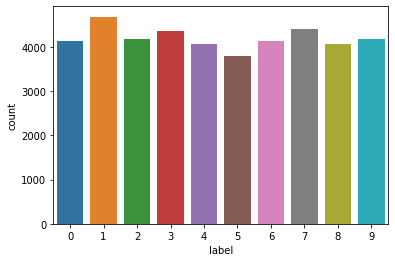

In [17]:
y_train = train["label"]

X_train = train.drop(labels = ["label"], axis = 1)

g = sns.countplot(y_train)
y_train.value_counts()

### Checking Null / Missing Values

We check for corrupted images (images that contain missing values within). As a result there is no missing values in datasets `train` and `test`.

In [18]:
# Check train null/missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [19]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences, such that the CNN achieves faster convergence. Note that the CNN converges faster on [0..1] than on [0..255].

In [20]:
# Normalize data
X_train /= 255.0
test /= 255.0

# Reshape images to vectors
X_train, test = X_train.values.reshape(-1, 28, 28, 1), test.values.reshape(-1, 28, 28, 1)

### Label Encoding
The original images were labeled with digits (e.g. image 8 is labeled with '8'). We encode them to one-hot vectors. For instance, image 8 is labeled as vector [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].

In [21]:
y_train = to_categorical(y_train, num_classes = 10)

### Splitting Training Set for Validation


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = RAND_SEED)

### Some Samples from Data

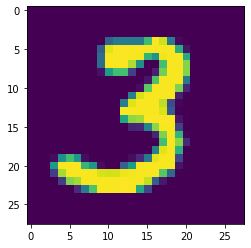

In [23]:
plt.imshow(X_train[6][:,:,0])

## CNN
### Defining the Model

In [24]:
# Initialize the CNN Model
# Model Architechture: 2 * [2 * [Conv2D -> relu] -> MaxPool2D -> Dropout] -> Flatten -> Dense -> Dropout -> Output]
model = Sequential()

########################################################################
# First 2 * [Conv2D -> relu] -> MaxPool2D -> Dropout

# 2 * Conv2D -> Relu Layers
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))

# MaxPool 2D Layer
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout Layer
model.add(Dropout(0.25))

########################################################################
# Second 2 * [Conv2D -> relu] -> MaxPool2D -> Dropout

# 2 * Conv2D -> Relu Layers
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))

# MaxPool 2D Layer
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Dropout Layer
model.add(Dropout(0.25))
########################################################################

# Flatten Layer
model.add(Flatten())

# Dense Layer
model.add(Dense(256, activation = "relu"))

# Dropout Layer
model.add(Dropout(.5))

# Output Softmax
model.add(Dense(10, activation = "softmax"))


In [25]:
# Defining the optimizer
optimizer = RMSprop(learning_rate = .001, rho = .9, epsilon = 1e-8, decay = 0.0)

In [26]:
# Copiling the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [27]:
# Setting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy",
                                            patience = 3,
                                            verbose = 1,
                                            factor = .5,
                                            min_lr = .00001)

In [28]:
# Change epoches to 30 to get .9967 accurary
epochs = 30 
batch_size = 86

## Augmenting Data

In [29]:
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,      # set each sample mean to 0
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                             zca_whitening = False,
                             rotation_range = 10,
                             zoom_range = .1,
                             width_shift_range = .1,
                             horizontal_flip = False,
                             vertical_flip = False)

datagen.fit(X_train)

In [30]:
# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [learning_rate_reduction])

Epoch 1/30
439/439 - 232s - loss: 0.3041 - accuracy: 0.9049 - val_loss: 0.0626 - val_accuracy: 0.9805
Epoch 2/30
439/439 - 220s - loss: 0.0984 - accuracy: 0.9708 - val_loss: 0.0492 - val_accuracy: 0.9850
Epoch 3/30
439/439 - 222s - loss: 0.0779 - accuracy: 0.9777 - val_loss: 0.0365 - val_accuracy: 0.9900
Epoch 4/30
439/439 - 217s - loss: 0.0632 - accuracy: 0.9814 - val_loss: 0.0374 - val_accuracy: 0.9890
Epoch 5/30
439/439 - 216s - loss: 0.0603 - accuracy: 0.9820 - val_loss: 0.0345 - val_accuracy: 0.9910
Epoch 6/30
439/439 - 214s - loss: 0.0537 - accuracy: 0.9848 - val_loss: 0.0286 - val_accuracy: 0.9929
Epoch 7/30
439/439 - 214s - loss: 0.0508 - accuracy: 0.9860 - val_loss: 0.0326 - val_accuracy: 0.9919
Epoch 8/30
439/439 - 215s - loss: 0.0484 - accuracy: 0.9855 - val_loss: 0.0280 - val_accuracy: 0.9921
Epoch 9/30
439/439 - 213s - loss: 0.0491 - accuracy: 0.9860 - val_loss: 0.0268 - val_accuracy: 0.9921

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
E

In [35]:
# Saving model
model.save("/drive/My Drive/keras-cnn-model")

INFO:tensorflow:Assets written to: /drive/My Drive/keras-cnn-model/assets


## Model Evaluation

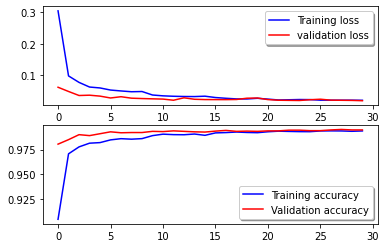

In [31]:
# Plot loss curves and accuracy curves for training/val
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history["loss"], color = 'b', label = "Training loss")
ax[0].plot(history.history["val_loss"], color = 'r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(history.history["accuracy"], color ='b', label = "Training accuracy")
ax[1].plot(history.history["val_accuracy"], color= 'r',label = "Validation accuracy")
legend = ax[1].legend(loc = "best", shadow = True)

In [32]:
# Predict results8
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = "Label")

In [33]:
submission = pd.concat([pd.Series(range(1, 28001), name = "ImageId"), results], axis = 1)
submission.to_csv("/drive/My Drive/cnn_mnist_datagen-30-epochs.csv", index = False)